# Sử dụng Poisson GLM như là Category Regression (Bayesian statistic)
BS. Vương Kiến Thanh

---
Hôm nay tôi sẽ giới thiệu mô hình phân loại (*Classification*) nhiều nhóm dựa trên mô hình tập hợp các Poission GLM, bằng phương pháp bayesian.  

Thực vậy, mô hình hồi quy Multinomial GLM phức tạp có thể được thay thế bằng nhiều Poisson GLM khác nhau, và dĩ nhiên nó đúng về mặt toán học. Hơn nữa, nó không computational expensive như Multinomial GLM.  

ĐỂ diễn đạt rõ hơn, tôi xin trình bày bài toán dựa trên dataset kinh điển **IRIS**, câu hỏi là dựa vào *sepal length (cm), sepal width (cm), petal length (cm), petal width (cm)* để **phân loại** hoa đó là hoa nào trong nhóm *setosa, versicolor, virginica*.

---
### Load data

In [1]:
from sklearn.datasets import load_iris

In [2]:
df = load_iris(as_frame=True)

In [3]:
df.data.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [4]:
df.target.head()

0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int64

In [5]:
df.target.unique()

array([0, 1, 2])

In [6]:
df.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

---
### *Poisson GLM* thay thế cho multinomial GLM trong bài toán iris classification

Chuẩn bị data theo format cần thiết

In [7]:
import jax.numpy as jnp
from jax import lax, random

import numpyro
import numpyro.distributions as dist
from numpyro.diagnostics import print_summary
from numpyro.infer import MCMC, NUTS, Predictive
import arviz as az
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

In [8]:
from sklearn.preprocessing import label_binarize

target = label_binarize(df.target, classes=[0,1,2])
target[:5]

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]])

Ở đây tôi thực hiện **one hot encoding** biến `target`.

Model:
Tôi chọn những prior chứa rất ít thông tin, do tôi chưa có nền tảng hay sự hiểu biết trước đó về các loài hoa.

#### Prior

$$\begin{matrix}
a_i   &\sim& \text{Normal} (0, 10) \\
bsl_i &\sim& \text{Normal} (0, 10) \\
bsw_i &\sim& \text{Normal} (0, 10) \\
bpl_i &\sim& \text{Normal} (0, 10) \\
bpw_i &\sim& \text{Normal} (0, 10) \\
\end{matrix}$$

#### Linear model
Với log link function cho các poisson model

$$\log(\lambda_i) = a_i + bsl_i + bsw_i + bpl_i + bpw_i$$

#### Likelihood

$$ \text{target}_i \sim \text{Poisson} (\lambda_i) $$



In [9]:
def model(sl, sw, pl, pw, target0=None, target1=None, target2=None):
    a = numpyro.sample("a", dist.Normal(0,10).expand([3]))
    bsl = numpyro.sample("bsl", dist.Normal(10).expand([3]))
    bsw = numpyro.sample("bsw", dist.Normal(10).expand([3]))
    bpl = numpyro.sample("bpl", dist.Normal(10).expand([3]))
    bpw = numpyro.sample("bpw", dist.Normal(10).expand([3]))
    
    lambda0 = numpyro.deterministic("lambda0",
        jnp.exp(a[0] + bsl[0]*sl + bsw[0]*sw + bpl[0]*pl + bpw[0]*pw))
    lambda1 = numpyro.deterministic("lambda1",
        jnp.exp(a[1] + bsl[1]*sl + bsw[1]*sw + bpl[1]*pl + bpw[1]*pw))
    lambda2 = numpyro.deterministic("lambda2",
        jnp.exp(a[2] + bsl[2]*sl + bsw[2]*sw + bpl[2]*pl + bpw[2]*pw))
    
    numpyro.sample('setosa',     dist.Poisson(lambda0), obs=target0)
    numpyro.sample('versicolor', dist.Poisson(lambda1), obs=target1)
    numpyro.sample('virginica',  dist.Poisson(lambda2), obs=target2)

---
### Chạy MCMC cho mô hình với 4 chains, 500 warm-ups, 2500 posterior samples cho mỗi chain.

In [10]:
m_pois = MCMC(NUTS(model), 500, 2500, num_chains=4)
m_pois.run(random.PRNGKey(0),
    df.data.iloc[:, 0].values,
    df.data.iloc[:, 1].values,
    df.data.iloc[:, 2].values,
    df.data.iloc[:, 3].values,
    target[:, 0],
    target[:, 1],
    target[:, 2])

/Volumes/DATA/anaconda3/envs/jupyter/lib/python3.8/site-packages/numpyro/infer/mcmc.py:429: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider to use `numpyro.set_host_device_count(4)` at the beginning of your program.
  warnings.warn('There are not enough devices to run parallel chains: expected {} but got {}.'


In [11]:
m_pois.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      a[0]     -2.23      1.73     -2.24     -5.19      0.46  10254.79      1.00
      a[1]     -1.53      1.52     -1.52     -4.01      1.00  10050.96      1.00
      a[2]     -9.98      1.74     -9.94    -12.88     -7.14   8802.76      1.00
    bpl[0]     -1.67      0.40     -1.66     -2.34     -1.04   6921.95      1.00
    bpl[1]     -0.08      0.33     -0.08     -0.63      0.46   5176.90      1.00
    bpl[2]      0.59      0.40      0.58     -0.09      1.22   7375.47      1.00
    bpw[0]      2.56      0.72      2.56      1.38      3.74   8424.35      1.00
    bpw[1]      0.59      0.53      0.59     -0.27      1.47   6912.23      1.00
    bpw[2]      2.48      0.50      2.48      1.65      3.31   9900.64      1.00
    bsl[0]     -0.39      0.47     -0.39     -1.16      0.40   7117.87      1.00
    bsl[1]      0.15      0.37      0.15     -0.44      0.78   6259.71      1.00
    bsl[2]     -0.11      0

MCMC này có n_eff khá lớn, để kiểm tra tính khả dụng của kết quả MCMC này, ta cần nhiều bước hơn, tôi xin không trình bày ở đây.

Nhìn sơ qua kết quả trace_plot, chúng ta sẽ tạm chấp nhận kết quả MCMC này.

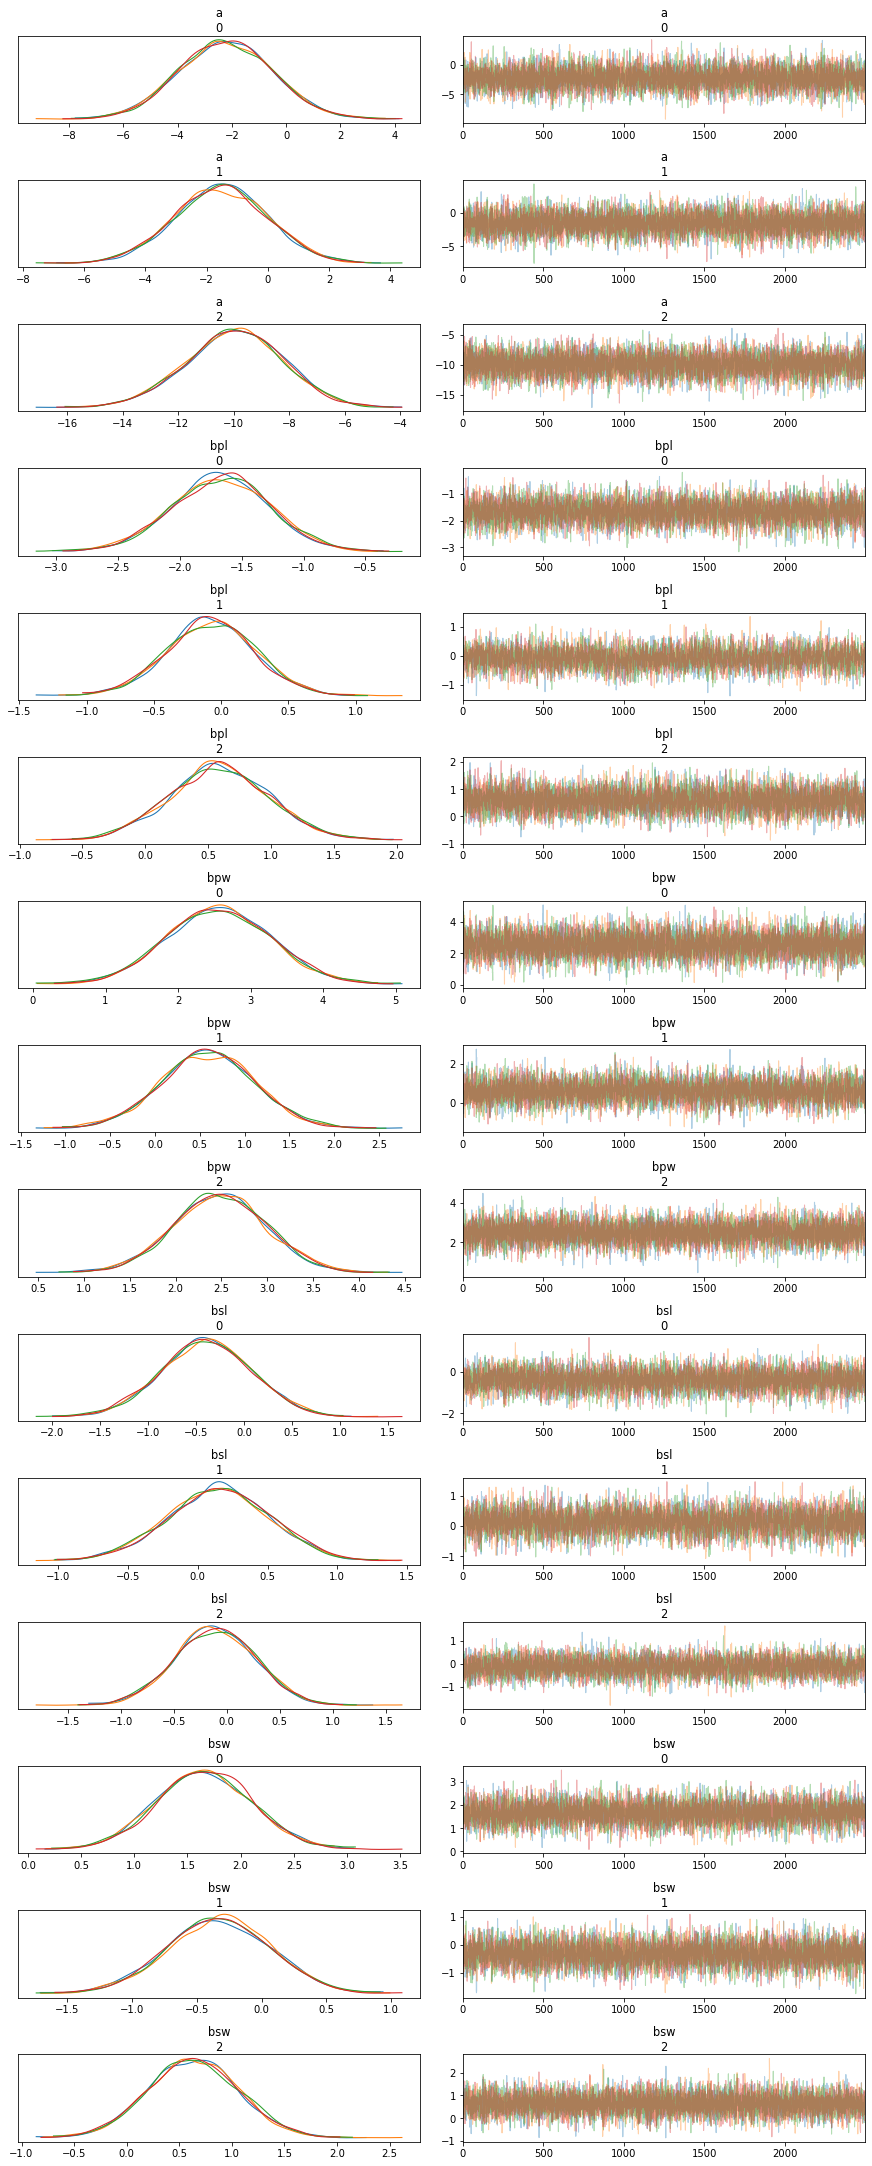

In [12]:
trace = m_pois.get_samples(group_by_chain=True)
trace = {k: trace[k] for k in ["a", "bpl", "bpw", "bsl", "bsw"]}
az.plot_trace(trace);

---
### Với những mô hình phức tạp, việc diễn giải mô hình là rất khó, cách tốt nhất là xem hiệu năng của mô hình đến đâu.

Để sử dụng mô hình Poisson này, ta nhìn vào kết quả posterior của các param $\lambda$.

Xác suất của từng nhóm sẽ theo công thức:

$$  p_i = \frac{\lambda_i} {\sum \lambda_i }$$

#### Đầu tiên, ta lấy mẫu posterior của các lambda

In [13]:
post = m_pois.get_samples()
predictor = Predictive(model, post, return_sites=['lambda0', 'lambda1', 'lambda2'])

#### Viết hàm tính khoảng tin cậy 95% và trung bình của xác suất phân nhóm các loại hoa.

In [14]:
def predict(predictor, *inp, seed=1):
    res = predictor(random.PRNGKey(seed), *inp)
    numerator = jnp.array(list(res.values()))
    denominator = jnp.sum(numerator, axis=0)
    p =  numerator / denominator
    return p

def implication(predictor, *inp, seed=1):
    p = predict(predictor, *inp, seed)
    index = ["setosa", "versicolor", "virginica"]
    columns = ['Mức dưới KTC 95%', 'Xác suất trung bình', 'Mức trên KTC 95%']
    res_df = pd.DataFrame(jnp.quantile(p, jnp.array([0.025, 0.5, 0.975]), axis=1).T,
                        index=index, columns=columns)
    return res_df.style.\
        bar(subset=['Xác suất trung bình'], color='lightgreen', vmax=1).\
        set_properties(**{'border': '1px solid black'})

#### Ví dụ với data point đầu tiên trong dataset

In [15]:
df.data.loc[0], df.target.loc[0]

(sepal length (cm)    5.1
 sepal width (cm)     3.5
 petal length (cm)    1.4
 petal width (cm)     0.2
 Name: 0, dtype: float64,
 0)

In [16]:
implication(predictor, *df.data.loc[0].values)

,Mức dưới KTC 95%,Xác suất trung bình,Mức trên KTC 95%
setosa,0.717417,0.836769,0.920499
versicolor,0.077899,0.161370,0.280230
virginica,0.000072,0.001019,0.010066


#### Ví dụ với data point 50, 100 của dataset

In [17]:
df.data.loc[50], df.target.loc[50]

(sepal length (cm)    7.0
 sepal width (cm)     3.2
 petal length (cm)    4.7
 petal width (cm)     1.4
 Name: 50, dtype: float64,
 1)

In [18]:
implication(predictor, *df.data.loc[50].values)

,Mức dưới KTC 95%,Xác suất trung bình,Mức trên KTC 95%
setosa,0.010535,0.044119,0.146603
versicolor,0.541231,0.757953,0.892855
virginica,0.068378,0.188981,0.400068


In [19]:
df.data.loc[100], df.target.loc[100]

(sepal length (cm)    6.3
 sepal width (cm)     3.3
 petal length (cm)    6.0
 petal width (cm)     2.5
 Name: 100, dtype: float64,
 2)

In [20]:
implication(predictor, *df.data.loc[100].values)

,Mức dưới KTC 95%,Xác suất trung bình,Mức trên KTC 95%
setosa,0.002841,0.015947,0.063634
versicolor,0.058520,0.135711,0.280548
virginica,0.689437,0.843156,0.929459


Để kiểm tra thêm hiệu năng của mô hình này, ta có thể dùng ROC, AUC, confusion matrix, cross-validation, ...  
Để cải thiện mô hình, ta có thể cần thêm nhiều mẫu MCMC, sửa lại linear model, ...

---
### Vẽ ROC curve

See: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

In [21]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

In [22]:
y_score = predict(predictor,
        df.data.iloc[:, 0].values,
        df.data.iloc[:, 1].values,
        df.data.iloc[:, 2].values,
        df.data.iloc[:, 3].values).mean(axis=1).T

y_pred = jnp.apply_along_axis(jnp.argmax, 1, y_score)

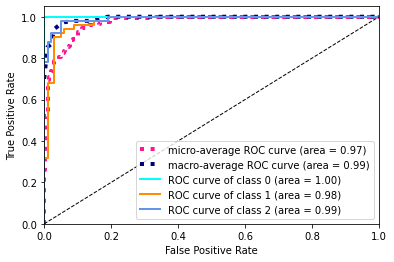

In [23]:
n_classes=3
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(target[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(target.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {} (area = {:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right");

Có vẻ mô hình đã bị overfitting. Nhưng đó là một bài toán khác.

---
## Kết luận:

Bài hôm nay tôi đã dùng Poisson GLM để thay thế cho Multinomial GLM trong bài toán phân nhóm nhiều nhóm bằng Bayesian.

Bài chứng minh sự tương đương này có thể được đọc ở: https://www.stat.tamu.edu/~suhasini/teaching613/chapter10.pdf

Cám ơn các bạn đã quan tâm.